# Menu <a class="anchor" id="menu"></a>
   
* [1. Introduction au Topic Modelling](#introduction)
* [2. Analyses Exploratoires des jeux de donn√©es](#EDA)
    * [2.1 yelp_academic_dataset_**business**.json](#EDA_business)
    * [2.2 yelp_academic_dataset_**review**.json](#EDA_reviews)
    * [2.3 Pr√©paration du jeu de donn√©es de travail](#data_work)
    * [2.4 Analyses du nouveau jeu de donn√©es](#multivariate_analysis)
* [3. Pr√©traitement des donn√©es](#pretraitement)
    * [3.1 Tokenization](#tokenize)
    * [3.2 Filtrage des tokens](#filter)
    * [3.3 Lemmatization des tokens](#lemmatize)
    * [3.4 Suppression des mots les plus fr√©quents](#most_frequents)
    * [3.5 Cr√©ation du Dictionnaire](#dict)
    * [3.6 Cr√©ation du Corpus Bag-Of-Words](#corpus_bow)
    * [3.7 Cr√©ation du Curpus TF-IDF](#corpus_tfidf)
* [4. Topic Modelling avec LDA](#lda_topic_modelling)
    * [4.1 Latent Dirichlet Allocation *(LDA)*](#lda)
    * [4.2 Recheche du nombre de sujets avec le score de coh√©rence](#lda_coherence)
    * [4.3 Log des courbes de coh√©rences pour divers essais](#lda_coherence_logs)
* [5. Topic Modelling avec NMF](#nmf_topic_modelling)
    * [5.1 Negative Matrix Factorisation *(NMF)*](#nmf)
    * [5.2 Recheche du nombre de sujets avec le score de coh√©rence](#nmf_coherence)
    * [5.3 Log des courbes de coh√©rences pour divers essais](#nmf_coherence_logs)
* [6. Choix et entrainement du mod√®le final](#final_model)
    * [6.1 Entrainement & interpr√©tation du meilleur mod√®le LDA](#final_model_lda)
    * [6.2 Entrainement & interpr√©tation du meilleur mod√®le NMF](#final_model_nmf)
    * [6.3 Export du mod√®le s√©lectionn√©](#final_model_export)

---
---
# 1. Introduction au Topic Modelling <a class="anchor" id="introduction"></a> [‚á™](#menu)

Un algorithme de topic modelling est un mod√®le math√©matique/statistique utilis√© pour d√©duire quels sont les sujets qui repr√©sentent le mieux les donn√©es.

Il est bas√©e sur les hypoth√®ses suivantes :
- Un texte (document) est compos√© de plusieurs sujets.
- Un sujet est compos√© d'une collection de mots

Le but de l'algorithme est de calculer une *note* de participation √† un th√®me donn√© pour chaque mot d'un texte, et pour y parvenr nous allons suivre les √©tapes ci-dessous:

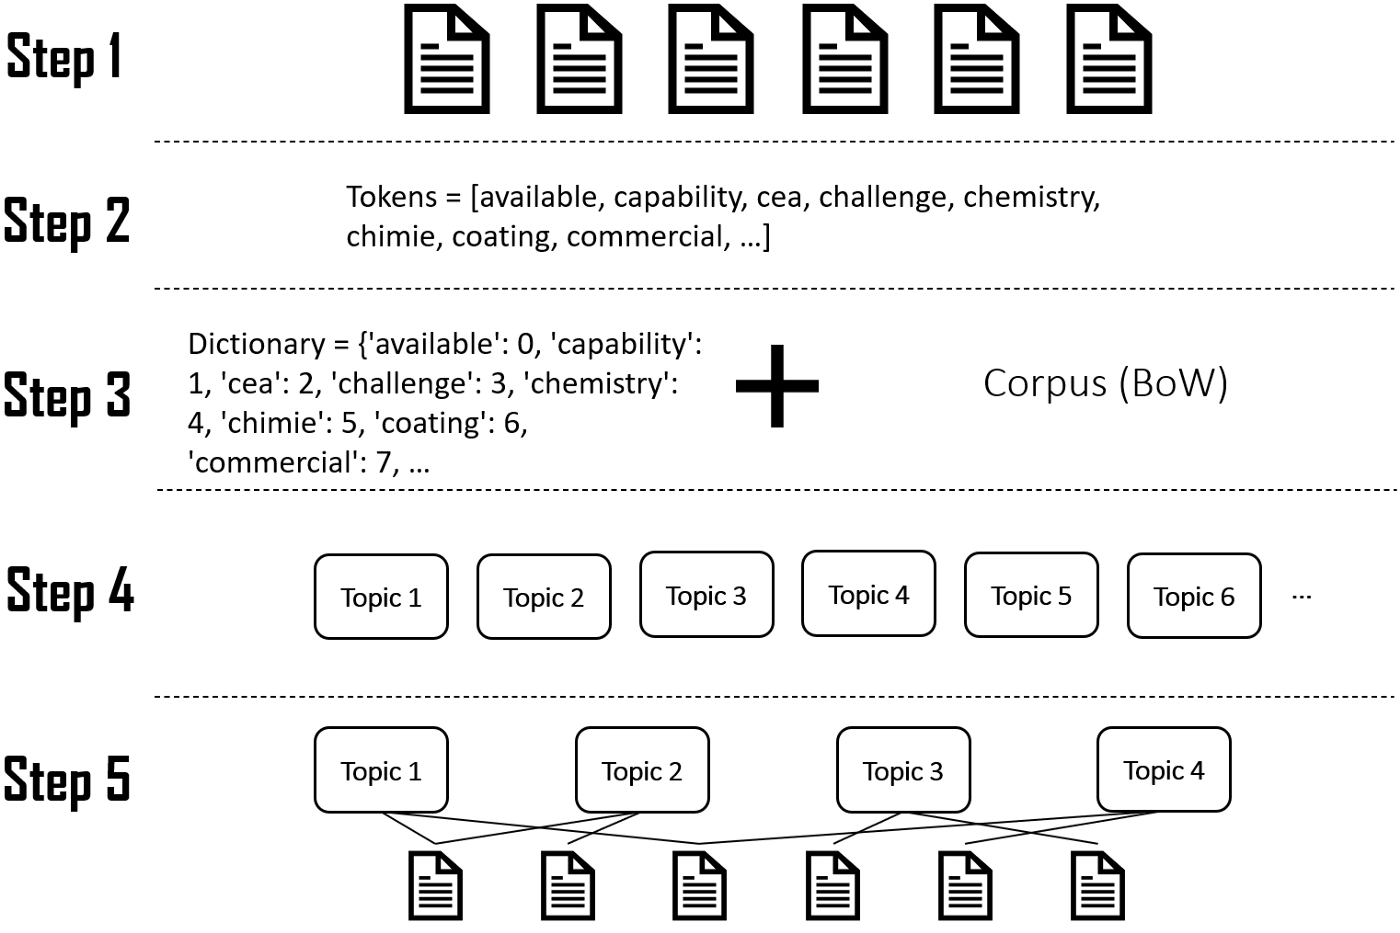

- **Step1** : consiste √† *r√©cup√®rer les donn√©es* et √† *conduire une Analyse Exploratoire des donn√©es*.
- **Step2** : consiste √† *tokeniser* les textes *(c'est √† dire d√©couper les phrases mot √† mot)*.
- **Step3** : consiste √† *cr√©er un dictionnaire associant chaque mot √† un ID unique* puis √† *cr√©er un Bag Of Words* repr√©sentant la fr√©quence des tokens. 
- **Step4** : consiste √† *construire un mod√®le permettant d'identifier les sujets* puis √† l'ajuster *trouver le nombre optimal de sujets*.
- **Step5** : consiste √† *utiliser le mod√®le cr√©e* pour connaitre la distribution des sujets identifi√©s dans les *(potentiellement nouveaux)* documents.

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# import pyLDAvis
# import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
import spacy_fastlang
from collections import Counter
from pprint import pprint
from tqdm import tqdm
# from tqdm.notebook import tqdm

# import logging
# logging.captureWarnings(True)
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')
# warnings.filterwarnings("ignore", category=DeprecationWarning) 
# warnings.filterwarnings("ignore", message=".*the imp module is deprecated in favour of importlib;(.|\n)*") # supports regular expressions

random_seed = 0
np.random.seed(random_seed)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
def get_num_lines(path):
    with open(path) as f:
        for i, _ in enumerate(f):
            pass
    return i+1

In [3]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, show_percent=False, x_label=None, y_label=None, **args):
    
    if show_percent:
        total = data_.values.sum()
        data_ = round(data_/total*100.0,2)

    fig = plt.figure(figsize=(15, 4))
    
    ax = sns.barplot(data=data_, **args)
    
    if show_values:
        ax.bar_label(ax.containers[0])
        
    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

---
---
# 2. Analyses Exploratoires <a class="anchor" id="EDA"></a> [‚á™](#menu)

## 2.1 `yelp_academic_dataset_business.json` <a class="anchor" id="EDA_business"></a> [‚á™](#menu)

In [4]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_business.json")
data_business = pd.read_json(file_path, lines=True)  # 150346 x 14
display(data_business.head(2), data_business.shape)

business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   

                               attributes  \
0           {'ByAppointmentOnly': 'True'}   
1  {'BusinessAcceptsCreditCards': 'True'}   

                                          categories  \
0  Doctors, Traditional Chinese Medicine, Naturop...   
1  Shipping Centers, Local Services, Notaries, Ma...   

                                               hours  
0                                               None  
1  {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...

(150346, 14)

In [5]:
data_business.categories.value_counts()

Beauty & Spas, Nail Salons                                                                                       1012
Restaurants, Pizza                                                                                                935
Nail Salons, Beauty & Spas                                                                                        934
Pizza, Restaurants                                                                                                823
Restaurants, Mexican                                                                                              728
                                                                                                                 ... 
Dermatologists, Health & Medical, Cosmetic Surgeons, Doctors, Acne Treatment, Skin Care, Beauty & Spas              1
Home Services, Home & Garden, Nurseries & Gardening, Hardware Stores, Shopping, Building Supplies, Appliances       1
Food Trucks, Smokehouse, Restaurants, Food, Barbeque, So

In [6]:
data_business.categories.str.contains('Restaurant').value_counts(dropna=False)

False    97957
True     52286
None       103
Name: categories, dtype: int64

>#### Il y a visiblement beaucoup de commerces qui ne sont pas des restaurants... on va donc devoir trouver un moyen d'isoler les reviews qui concernent les restaurants.

### Pr√©paration d'un jeu de donn√©es regroupants les business qui sont des restaurants

In [7]:
data_restaurant = data_business[data_business.categories.str.contains("Restaurant") == True]
display(data_restaurant.head(2), data_restaurant.shape)

business_id                name        address          city  \
3  MTSW4McQd7CbVtyjqoe9mw  St Honore Pastries    935 Race St  Philadelphia   
5  CF33F8-E6oudUQ46HnavjQ      Sonic Drive-In  615 S Main St  Ashland City   

  state postal_code   latitude  longitude  stars  review_count  is_open  \
3    PA       19107  39.955505 -75.155564    4.0            80        1   
5    TN       37015  36.269593 -87.058943    2.0             6        1   

                                          attributes  \
3  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
5  {'BusinessParking': 'None', 'BusinessAcceptsCr...   

                                          categories  \
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
5  Burgers, Fast Food, Sandwiches, Food, Ice Crea...   

                                               hours  
3  {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...  
5  {'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...

(52286, 14)

## 2.2 `yelp_academic_dataset_review.json` <a class="anchor" id="EDA_reviews"></a> [‚á™](#menu)

In [8]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_review.json")
data_review = pd.read_json(file_path, lines=True, nrows=1000000)  # 6990280 x 9
display(data_review.head(2), data_review.shape)

review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      5       1      0     1   

                                                text                date  
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year... 2012-01-03 15:28:18

(1000000, 9)

In [9]:
(get_num_lines(file_path), data_review.shape[1])

(6990280, 9)

### Regardons plus en d√©tails les variables du jeu de donn√©es

#### Les variables qualitatives

In [10]:
data_review.describe(exclude=['number','datetime']).T

count   unique  \
review_id    1000000  1000000   
user_id      1000000   542003   
business_id  1000000    27095   
text         1000000   998357   

                                                           top  freq  
review_id                               KU_O5udG6zpxOg-VcAEodg     1  
user_id                                 _BcWyKQL16ndpBdggh2kNA   483  
business_id                             GBTPC53ZrG1ZBY3DT8Mbcw  4661  
text         I have eaten at just about every decent Indian...     5

#### Les variables quantitatives

In [11]:
data_review.describe(datetime_is_numeric=True).T

count                           mean                  min  \
stars   1000000.0                       3.783959                  1.0   
useful  1000000.0                       1.106594                  0.0   
funny   1000000.0                       0.307812                  0.0   
cool    1000000.0                       0.457129                  0.0   
date      1000000  2016-07-13 10:09:02.464016128  2005-03-01 17:47:15   

                               25%                  50%  \
stars                          3.0                  4.0   
useful                         0.0                  0.0   
funny                          0.0                  0.0   
cool                           0.0                  0.0   
date    2014-08-07 16:29:16.500000  2016-10-11 16:02:42   

                                  75%                  max       std  
stars                             5.0                  5.0  1.440197  
useful                            1.0                539.0  2.848906  
funny                             0.0                284.0  1.428185  
cool                              0.0                172.0  1.799114  
date    2018-09-01 01:26:22.249999872  2022-01-19 19:47:59       NaN

## 2.3 Pr√©paration du jeu de donn√©es de travail <a class="anchor" id="data_work"></a> [‚á™](#menu)

### Supprimons les reviews qui ne concernent pas des restaurants et gardons uniquement les colonnes utiles pour la suite

In [12]:
join_restaurant_reviews = data_review.merge(data_restaurant, on='business_id', how='left')

In [13]:
join_restaurant_reviews.categories.value_counts(dropna=False)

NaN                                                                                                                                   310481
Restaurants, Mexican                                                                                                                    7915
Mexican, Restaurants                                                                                                                    6219
Restaurants, Pizza                                                                                                                      4760
German, Restaurants, Seafood, Cocktail Bars, French, Brasseries, American (New), Nightlife, Bars, Cajun/Creole, Breakfast & Brunch      4661
                                                                                                                                       ...  
Pakistani, Restaurants                                                                                                                     1
Imported Food

In [14]:
data_review_restos = join_restaurant_reviews[['stars_x', 'text', 'user_id', 'business_id', 'review_id']][join_restaurant_reviews.categories.notnull()]
data_review_restos.rename(columns={'stars_x':'stars'}, inplace=True)
display(data_review_restos.head(2), data_review_restos.shape)

stars                                               text  \
0      3  If you decide to eat here, just be aware it is...   
2      3  Family diner. Had the buffet. Eclectic assortm...   

                  user_id             business_id               review_id  
0  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw  KU_O5udG6zpxOg-VcAEodg  
2  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A  saUsX_uimxRlCVr67Z4Jig

(689519, 5)

### Supprimons les √©ventuels doublons

#### V√©rifions tout d'abord si l'on a des doublons sur la base des colonnes que nous avons gard√©s

In [15]:
data_review_restos.duplicated().sum()

0

#### Mais il se pourrait que chaque review ait bien un ID unique alors que l'on a plusieurs fois les m√™mes textes par un m√™me client sur le m√™me restaurant...

In [16]:
subset = ['stars', 'text', 'user_id', 'business_id']
data_review_restos.duplicated(subset=subset).sum()

1003

#### Comparons quelque uns de ces duplicatas pour v√©rifier...

In [17]:
data_review_restos[data_review_restos.duplicated(subset=subset, keep='first')].sort_values('text').head()

stars                                               text  \
586767      5  "Prep's Breakfast Sammie" is the BEST breakfas...   
416542      2  "We ran out of bread" they said, as we drove o...   
460249      1  "Who's in the kitchen and why can't they do th...   
202235      2  2 stars for cheap drinks. I was happy to see t...   
684442      1  20 minutes and no server. Owner finally took a...   

                       user_id             business_id               review_id  
586767  Xf5hPJl9P4r9rRAy-NR46g  UCMSWPqzXjd7QHq7v8PJjQ  Oz8E7WQ5JVlrCC6-PGdY8Q  
416542  oUzXQqxXkFGL5k1OEmFr4g  34Eqv8jXgxg_EEwcsNgeeg  CF4rf7--EneYMVHAPgX7Jg  
460249  CL5U0V87_Ord4cp9pE40Pw  XQfwVwDr-v0ZS3_CbbE5Xw  PnqDAlcL2-S9oOgn34Lzkw  
202235  ce9ZWyllsjOGHtdu6NpZww  4yKv0SEpuJDHECFinhifWQ  r_FsYzzKJG4wCgebF7e_sQ  
684442  dTY6QRU-ox_HqX1A7I88tw  Ea2hPSFazxXITET4f6ZJhw  VNMwljSo3CGUwdiUQSukPg

In [18]:
data_review_restos[data_review_restos.duplicated(subset=subset, keep='last')].sort_values('text').head()

stars                                               text  \
498137      5  "Prep's Breakfast Sammie" is the BEST breakfas...   
322765      2  "We ran out of bread" they said, as we drove o...   
60045       1  "Who's in the kitchen and why can't they do th...   
134308      2  2 stars for cheap drinks. I was happy to see t...   
371454      1  20 minutes and no server. Owner finally took a...   

                       user_id             business_id               review_id  
498137  Xf5hPJl9P4r9rRAy-NR46g  UCMSWPqzXjd7QHq7v8PJjQ  uZ0nZRQ-RpttoLCym2DyHw  
322765  oUzXQqxXkFGL5k1OEmFr4g  34Eqv8jXgxg_EEwcsNgeeg  mSKC9E97PpwdB3L3Jnxc2A  
60045   CL5U0V87_Ord4cp9pE40Pw  XQfwVwDr-v0ZS3_CbbE5Xw  241ycTAVakh4sY8b7S_jyQ  
134308  ce9ZWyllsjOGHtdu6NpZww  4yKv0SEpuJDHECFinhifWQ  z2Cl4obOdxpC1uDnnsdnQw  
371454  dTY6QRU-ox_HqX1A7I88tw  Ea2hPSFazxXITET4f6ZJhw  SdHOvSqwRRZHaX-ON8QEmw

#### On a effectivement quelques doublons qu'il vaudrait mieux nettoyer pour √©viter de mettre plus de poids sur certains mots

In [19]:
print("AVANT:", data_review_restos.shape)
data_review_restos.drop_duplicates(subset=subset, inplace=True)
print("APR√àS:", data_review_restos.shape)

AVANT: (689519, 5)
APR√àS: (688516, 5)


#### Enfin supprimons les colonnes qui ne servaient qu'√† v√©rifier la pr√©sence de doublons

In [20]:
data_review_restos = data_review_restos[['stars', 'text']]

## 2.4 Analyses du nouveau jeu de donn√©es <a class="anchor" id="multivariate_analysis"></a> [‚á™](#menu)

#### Les variables qualitatives

In [21]:
data_review_restos.describe(exclude=['number','datetime']).T

count  unique                                                top freq
text  688516  688358  At the height of the Omicron surge, Wendy's DO...    4

#### Les variables quantitatives

In [22]:
data_review_restos.describe(datetime_is_numeric=True).T

count      mean       std  min  25%  50%  75%  max
stars  688516.0  3.801225  1.368445  1.0  3.0  4.0  5.0  5.0

### R√©partition de la taille des reviews

In [23]:
data_tmp = data_review_restos.copy()
data_tmp['review_size'] = data_review_restos.text.apply(lambda x: len(x.split()))

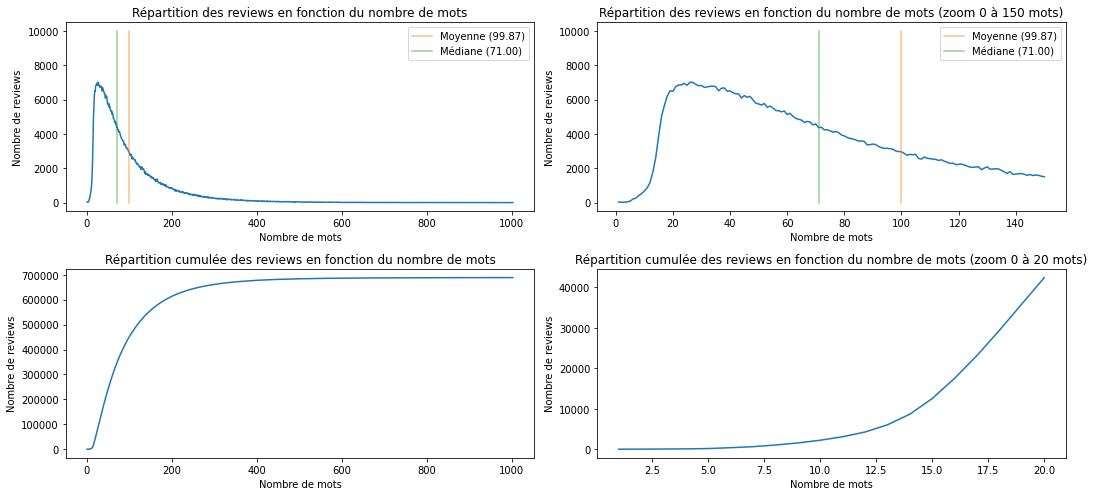

In [24]:
select = pd.DataFrame(data_tmp.review_size.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

review_size_mean = data_tmp.review_size.mean()
review_size_median = data_tmp.review_size.median()

fig = plt.figure(figsize=(15, 7))
plt.subplot(2,2,1)
sns.lineplot(data=select, y='review_size', x='index')
plt.plot([review_size_mean,review_size_mean],[0,10000], label=f"Moyenne ({review_size_mean:.2f})", alpha=0.5)
plt.plot([review_size_median,review_size_median],[0,10000], label=f"M√©diane ({review_size_median:.2f})", alpha=0.5)
plt.title("R√©partition des reviews en fonction du nombre de mots")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de reviews")
#plt.ylim(0,10000)
plt.legend()

plt.subplot(2,2,2)
zoom_left, zoom_right = 0, 150
sns.lineplot(data=select[zoom_left:zoom_right], y='review_size', x='index')
plt.plot([review_size_mean,review_size_mean],[0,10000], label=f"Moyenne ({review_size_mean:.2f})", alpha=0.5)
plt.plot([review_size_median,review_size_median],[0,10000], label=f"M√©diane ({review_size_median:.2f})", alpha=0.5)
plt.title(f"R√©partition des reviews en fonction du nombre de mots (zoom {zoom_left} √† {zoom_right} mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de reviews")
#plt.ylim(0,10000)
plt.legend()

select2 = np.cumsum(select)

plt.subplot(2,2,3)
sns.lineplot(data=select2, y='review_size', x='index')
#plt.plot([xxx,xxx],[0,10000], label="Moyenne", alpha=0.5)
plt.title("R√©partition cumul√©e des reviews en fonction du nombre de mots")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de reviews")

plt.subplot(2,2,4)
zoom_left, zoom_right = 0, 20
sns.lineplot(data=select2[zoom_left:zoom_right], y='review_size', x='index')
plt.title(f"R√©partition cumul√©e des reviews en fonction du nombre de mots (zoom {zoom_left} √† {zoom_right} mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de reviews")

plt.tight_layout()
plt.show()

In [25]:
data_tmp.review_size.describe()

count    688516.000000
mean         99.865116
std          92.380733
min           1.000000
25%          40.000000
50%          71.000000
75%         128.000000
max        1003.000000
Name: review_size, dtype: float64

In [26]:
data_tmp[ data_tmp.review_size > 457 ].shape

(6855, 3)

>#### On constate que :
> - la moiti√© des reviews ont moins de 75 "mots"
> - 48 des 1.000.000 de reviews ont 1 "mot"...
> - 275 des 1.000.000 de reviews ont 5 "mots" ou moins.
> - environ 800.000 des 1.000.000 de reviews ont moins de 150 "mots"

---
>#### `TODO`  done ‚úÖ | todo ‚ùå |

> - ‚úÖ Il faut supprimer les outliers. Ils risquent d'utiliser des mots non r√©pr√©sentatifs.
<br><u>*(action: fait ci-dessous)*</u>

#### Supprimons les outliers avec trop de textes et qui risquent donc d'utiliser des mots non repr√©sentatifs

In [27]:
data_clean = data_tmp[ data_tmp.review_size < data_tmp.review_size.quantile(0.99)]
display(data_clean.head(2), data_clean.shape)

stars                                               text  review_size
0      3  If you decide to eat here, just be aware it is...          101
2      3  Family diner. Had the buffet. Eclectic assortm...           55

(681611, 3)

### Explorons un peu les textes qui n'ont √©t√© d√©coup√©s qu'en un seul "mot"

In [28]:
print(data_clean.text[ data_clean.review_size == 1 ][:20])

27539                                                   Boo
67931     ÊÑèÈ§êÔºåËê•‰∏öÂà∞Êôö‰∏ä10ÁÇπÔºåmixÁöÑÂä†Â∑ûÁ∫¢ÈÖíÂæàÂ•ΩÔºåËøôÈáåÊúâÊÑèÂ§ßÂà©ÂíåÂä†Â∑ûÁöÑËë°ËêÑÈÖíÔºåÁâõÊéíÁ®çÂæÆËøáÁÜü‰∫ÜÔºå‰∫∫...
69333                                               Awesome
142373    Â§™ÁæéÂë≥ÔºÅËøûÁª≠ÂêÉ‰∫Ü‰∏§‰∏™Êôö‰∏äÔºåÊòØÂú®ÁæéÂõΩÂ∞ëÊúâÁöÑÈ≤úÁæéÔºåËÄåÁéØÂ¢ÉÂèàÈùûÂ∏∏‰∏çÈîô„ÄÇÊò®Â§©ÁöÑÊãÖÊãÖÈù¢„ÄÅÈ¶ôËèáÈùíËèúÈÉΩÂæàÂ•Ω...
144918                                           C'mon!!!!!
183565                                                  Lll
184566                                                  Wow
259830    ÊãõÁâåÊ≤ôÊãâÂ∞±ÊòØÁîüËèúÂè∂ÊãåÂí∏Âë≥Ê≤ôÊãâÈÖ±ÔºåÊòüÊúüÂõõÁâπ‰æõÁöÑÁÇíÈ•≠Â∞±ÊòØÂâ©È•≠ÁÇíÈ•≠ÔºåÁªøÊ¥ãËë±È¶ôËÇ†ÁöÑÂë≥ÈÅìÂÆûÂú®‰∏çÊï¢ÊÅ≠Áª¥Ôºå...
265618                                                    .
267429    „ÉÄ„Ç¶„É≥„Çø„Ç¶„É≥„ÅÆÂ§ñ„Çå„Å´„ÅÇ„ÇãÈùô„Åã„Å™„É¨„Çπ„Éà„É©„É≥„ÄÇ„Éá„Ç£„Éä„Éº„ÇíÈ£ü„Åπ„Å´Ë°å„Å£„Åü„Åå„ÄÅ„Ç™„Ç∑„É£„É¨„Å™Á©∫Èñì„ÅÆÂâ≤„Å´Èùô„Åã...
352724                                    

>#### On constate que:
> - il y a de nombreux textes qui ne sont pas en Anglais...
> - il y a des url seules
> - il y a des smileys seuls
> - il y a des mots seuls

---
>#### `TODO`  done ‚úÖ | todo ‚ùå |
> - ‚úÖ Il faut faire en sorte de ne garder que les textes en Anglais.
<br><u>*(action: fait juste apr√®s la tokenization)*</u>
> - ‚ùå Il faut supprimer les entr√©es avec des URL seules.
> - ‚úÖ Il faut supprimer les reviews d'un seul mot *(elles ne sont que 48 sur 1 millions si l'on compte les langues asiatiques mal splitt√©es)*.
<br><u>*(action: fait ci-dessous)*</u>

#### Supprimons les outliers avec trop peu de textes

In [29]:
data_clean = data_clean[ data_clean.review_size > 1 ][['stars','text']]
display(data_clean.head(2), data_clean.shape)

stars                                               text
0      3  If you decide to eat here, just be aware it is...
2      3  Family diner. Had the buffet. Eclectic assortm...

(681571, 2)

### R√©partition des notes *(stars)* des reviews

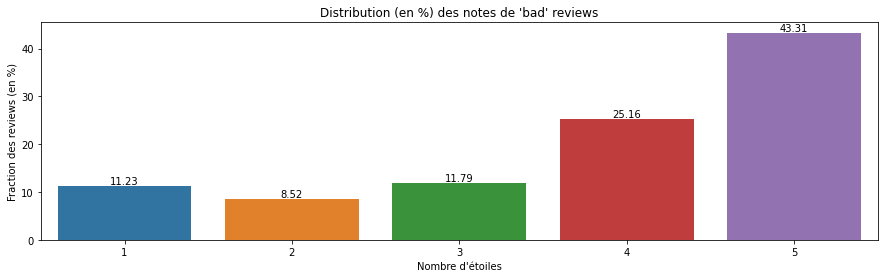

In [30]:
select = pd.DataFrame(data_clean.stars.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

plot_bars(select.T, "Distribution (en %) des notes de 'bad' reviews", y_label="Fraction des reviews (en %)", x_label="Nombre d'√©toiles", labels_rotation=0, show_percent=True)

>#### Nous constatons que la majorit√© des clients semblent satisfaits.
> Mais dans le cadre de notre projets nous voulons surtout identifier *les sujets qui pr√©occupent les personnes ayant laiss√© une mauvaise note*.<br>
> Nous allons donc travailler sur un √©chantillon de reviews dont les notes sont de 1 ou 2.

#### Binarisation du jeu de donn√©es

In [31]:
data_clean['is_low'] = data_clean.stars <= 2 # TRUE with 1,2 stars and FALSE with 3,4,5 stars
display(data_clean.head(2), data_clean.shape)

stars                                               text  is_low
0      3  If you decide to eat here, just be aware it is...   False
2      3  Family diner. Had the buffet. Eclectic assortm...   False

(681571, 3)

In [32]:
data_clean[data_clean.is_low].shape

(134575, 3)

>#### On a donc environ 216k "mauvaises" reviews √† utiliser *(en aillant limit√© le nombre initial de reviews charg√©es √† 1000k)*

#### S√©lection au hasard des "mauvaises" reviews *(en conservant le ratio initial des notes)*

In [33]:
sample_size = 10000

In [34]:
# Select samples with the original dataset stars' ratio
data_bad_reviews = data_clean[data_clean.is_low == True].sample(sample_size, random_state=random_seed)[['stars', 'text']].reset_index(drop=True)
display(data_bad_reviews.head(2), data_bad_reviews.shape)

stars                                               text
0      1  The crust was severely burned. The taste was s...
1      2  Eating outdoor was nice. Environment was nice....

(10000, 2)

#### Affichage de la distribution des scores dans le nouveau dataset

In [35]:
select = pd.DataFrame(data_bad_reviews.stars.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

plot_bars(select.T, "Distribution (en %) des notes de 'bad' reviews", y_label="Fraction des reviews (en %)", x_label="Nombre d'√©toiles", labels_rotation=0, show_percent=True)

---
---
# 3. Pr√©traitement des donn√©es <a class="anchor" id="pretraitement"></a> [‚á™](#menu)

Nous allons utiliser pour pr√©parer les donn√©es √† l'analyse, une biblioth√®que open-source appel√©e [spaCy](http://spacy.io), mais d'autres biblioth√®ques telles que [NLTK](https://www.nltk.org) peuvent √©galement √™tre utilis√©es.

Au cours du processus de Tokenisation, *spaCy* va ajouter plusieurs informations au document, que nous pourrons utiliser ult√©rieurement *(comme le type de mot, sont lemme, etc.)*

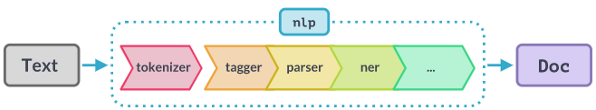

#### Visualisons le jeu de donn√©es avant la tokenisation

In [36]:
from wordcloud import WordCloud

In [37]:
from PIL import Image

In [38]:
def plot_wordcloud(text, from_frequency=False):
    alice_mask = np.array(Image.open("Documents/plate_shape.jpg"))
    
    # Create the wordcloud object (the size depends on the mask...)
    wordcloud = WordCloud(background_color="white", width=1000, height=700, margin=2, collocations=False, random_state=random_seed, mask=alice_mask)
    if from_frequency:
        wordcloud = wordcloud.generate_from_frequencies(text)
    else:
        wordcloud = wordcloud.generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(15, 10.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

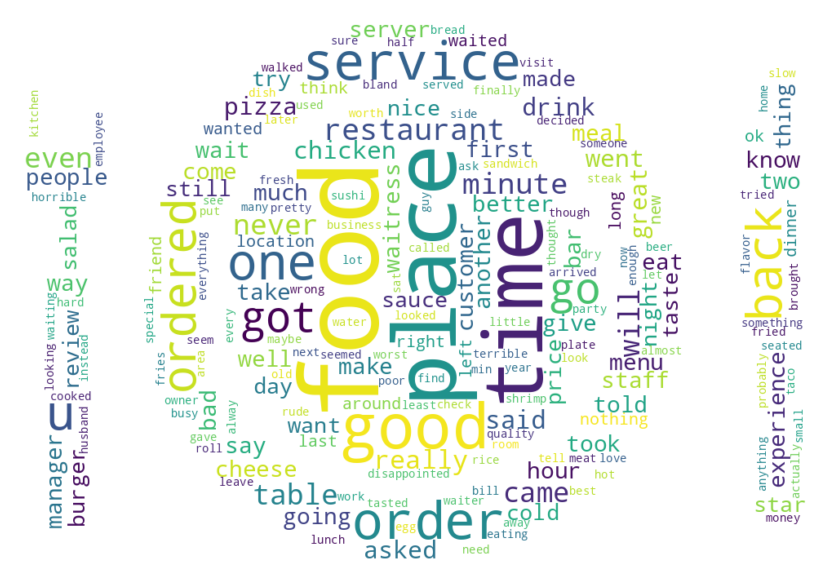

In [39]:
plot_wordcloud(" ".join([x for x in data_bad_reviews.text]))

## 3.1 Tokenization <a class="anchor" id="tokenize"></a> [‚á™](#menu)
>#### Nous allons profiter de cette √©tape de tokenisation pour supprimer:
> - les majuscules,
> - ~~les espaces en d√©but et fin de texte.~~
> - tout ce qui n'est pas d√©tect√© comme √©tant de l'anglais,
> - la ponctuation,
> - les stop-words,
> - les espaces,
> - les chiffres,
> - les ADVerbes.
>
>#### Par ailleurs on va utiliser les **lemmes** *(ra√ßines contextualis√©es)* des mots pour rassembler ceux qui sont assez similaires.

In [40]:
!python -m spacy download en_core_web_sm -qq
#!python -m spacy download en_core_web_md -qq
nlp = spacy.load('en_core_web_sm')

2022-06-28 16:20:32.945802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 16:20:32.945851: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
‚úî Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [41]:
nlp.add_pipe("language_detector")

In [42]:
def tokenize(text):

    # suppression des majuscules
    text = text.lower()

    # suppression des espaces au d√©but et √† la fin des textes
    text = text.strip()

    # tokenisation
    return nlp(text)

> pos_ tag ist
>
> - `ADJ`: adjective, e.g. big, old, green, incomprehensible, first
> - `ADP`: adposition, e.g. in, to, during
> - `ADV`: adverb, e.g. very, tomorrow, down, where, there
> - `AUX`: auxiliary, e.g. is, has (done), will (do), should (do)
> - `CONJ`: conjunction, e.g. and, or, but
> - `CCONJ`: coordinating conjunction, e.g. and, or, but
> - `DET`: determiner, e.g. a, an, the
> - `INTJ`: interjection, e.g. psst, ouch, bravo, hello
> - `NOUN`: noun, e.g. girl, cat, tree, air, beauty
> - `NUM`: numeral, e.g. 1, 2017, one, seventy-seven, IV, MMXIV
> - `PART`: particle, e.g. ‚Äôs, not,
> - `PRON`: pronoun, e.g I, you, he, she, myself, themselves, somebody
> - `PROPN`: proper noun, e.g. Mary, John, London, NATO, HBO
> - `PUNCT`: punctuation, e.g. ., (, ), ?
> - `SCONJ`: subordinating conjunction, e.g. if, while, that
> - `SYM`: symbol, e.g. $, %, ¬ß, ¬©, +, ‚àí, √ó, √∑, =, :), üòù
> - `VERB`: verb, e.g. run, runs, running, eat, ate, eating
> - `X`: other, e.g. sfpksdpsxmsa
> - `SPACE`: space, e.g. 

In [43]:
display(data_bad_reviews.head(2), data_bad_reviews.shape)

stars                                               text
0      1  The crust was severely burned. The taste was s...
1      2  Eating outdoor was nice. Environment was nice....

(10000, 2)

In [44]:
data_bad_reviews['spacy_doc'] = data_bad_reviews.text.apply(tokenize)

In [45]:
display(data_bad_reviews.head(2), data_bad_reviews.shape)

stars                                               text  \
0      1  The crust was severely burned. The taste was s...   
1      2  Eating outdoor was nice. Environment was nice....   

                                           spacy_doc  
0  (the, crust, was, severely, burned, ., the, ta...  
1  (eating, outdoor, was, nice, ., environment, w...

(10000, 3)

## 3.2 Filtrage des tokens <a class="anchor" id="filter"></a> [‚á™](#menu)

In [46]:
def filter_tokens(doc, except_words = []):

    # suppression des majuscules
    # text = text_.lower()

    # suppression des espaces au d√©but et √† la fin des textes
    #text = text.strip()

    # tokenisation
    # doc = nlp(text)
    # spacy.displacy.render(doc, style='dep',jupyter=True)
    
    # suppression des stopwords, de la ponctuation, des espaces et des adverbes et de ce qui n'est pas en anglais
    tokens = [token for token in doc 
              if not token.is_stop 
              and doc._.language == 'en'
              and doc._.language_score > 0.7
              #and not token.is_punct
              #and not token.is_space 
              #and not token.is_digit 
              and token.is_alpha
              and token.pos_ not in ['ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM'] 
              and token.lemma_ not in except_words
             ]
        
    return tokens

#### Regardons si il y a des textes dans d'autres langues ou dans de l'anglais approximatif

In [47]:
for doc in data_bad_reviews.spacy_doc:
    # is in english
    if doc._.language != 'en':
        print("NOT ENGLISH:\n", doc, "\n", "-"*50)
    elif doc._.language_score <= 0.7:
        print(f"GIBBERISH:{doc._.language_score}\n", doc, "\n", "-"*50)

NOT ENGLISH:
 n√£o compro no mercado brasileiro com frequ√™ncia, por√©m cada vez vejo menos variedade e menos empenho por parte dos funcion√°rios quanto ao atendimento. alguns funcion√°rios n√£o s√£o receptivos, n√£o se colocam √† disposi√ß√£o, e n√£o falam ingl√™s ou portugu√™s. n√£o sei quais s√£o as condi√ß√µes de trabalho, mas como consumidora tenho menos interesse. 
 --------------------------------------------------
NOT ENGLISH:
 „É™„Éé„Å´„ÅØ„Ç§„É≥„ÉâÊñôÁêÜÂ∫ó„ÅåÔºíÂ∫ó„ÅÇ„Çä„Åæ„Åô„ÄÇ„Åì„ÅÆÂ∫ó„ÅØÂè§„Åè„Åã„Çâ„ÅÇ„Çä„ÄÅÊï∞Âπ¥Ââç„Å´Â∫óËàó„ÅÆÊã°Âºµ„Åô„Çã„Åª„Å©„ÄÅÁæéÂë≥„Åó„Åè„Å´„Çì„Åç„ÅÆ„ÅÇ„ÇãÂ∫ó"„Åß„Åó„Åü"„ÄÇ
ÊÆãÂøµ„Å™„Åå„Çâ„ÄÅÂÄã„ÄÖ„ÅÆ„Ç´„É¨„Éº„ÅÆÁâπÂæ¥„Åå„Å™„Åè„ÄÅÈ¶ôËæõÊñô„ÅÆÂë≥„Åå„Åó„Å™„ÅÑ„ÅÜ„Åà„Å´ÂÖ®„Å¶Âêå„Åò„Çà„ÅÜ„Å™Âë≥„Å´„Å™„Å£„Å¶„Åó„Åæ„ÅÑ„Åæ„Åó„Åü„ÄÇ
È¶ôËæõÊñô„ÅÆÂäπ„ÅÑ„ÅüÁæéÂë≥„Åó„ÅÑ„Ç´„É¨„Éº„Éê„ÉÉ„Éï„Çß„Å´Ë°å„Åç„Åü„ÅÑ„ÅÆ„Åß„ÅÇ„Çå„Å∞„ÄÅsouth lake tahoe„Åæ„ÅßË∂≥„Çí‰º∏„Å∞„Åô„Åì„Å®„Çí„Åä„Åô„Åô„ÇÅ„Åó„Åæ„Åô„ÄÇ 
 --------------------------------------------------
GIBBERISH:0.512038588

>#### On d√©couvre:
> - plusieurs textes en espagnol ou en japonais/chinois
> - un casier judiciaire
> - des textes r√©dig√©s en plusieurs langues

#### Appliquons un filtre pour nettoyer ces tokens
- Suppression des langues √©trang√®res *(ce qui n'est pas de l'Anglais)*
- Suppression des stop-words
- Suppression des mots qui ne sont pas compos√©s de lettres de l'alphabet

In [48]:
data_bad_reviews['tokens'] = data_bad_reviews.spacy_doc.apply(filter_tokens)

## 3.3 Lemmatization des tokens <a class="anchor" id="lemmatize"></a> [‚á™](#menu)

In [49]:
def lemmatize(doc):
    return [token.lemma_ for token in doc]

#### Lemmatisons les tokens

In [50]:
data_bad_reviews['lemmas'] = data_bad_reviews.tokens.apply(lemmatize)

In [51]:
display(data_bad_reviews.head(2), data_bad_reviews.shape)

stars                                               text  \
0      1  The crust was severely burned. The taste was s...   
1      2  Eating outdoor was nice. Environment was nice....   

                                           spacy_doc  \
0  (the, crust, was, severely, burned, ., the, ta...   
1  (eating, outdoor, was, nice, ., environment, w...   

                                              tokens  \
0   [crust, burned, taste, sub, hands, worst, pizza]   
1  [eating, outdoor, nice, environment, nice, ok,...   

                                              lemmas  
0        [crust, burn, taste, sub, hand, bad, pizza]  
1  [eat, outdoor, nice, environment, nice, ok, bl...

(10000, 5)

#### Visualisons le jeu de donn√©es apr√®s la tokenisation

In [52]:
def get_all_lemmas(data):
    all_lemmas = []
    for tokens in data:
        all_lemmas.extend(tokens)
    return all_lemmas

all_lemmas = get_all_lemmas(data_bad_reviews.lemmas)

In [53]:
plot_wordcloud(" ".join(all_lemmas))

## 3.4 Suppression des mots les plus fr√©quents <a class="anchor" id="most_frequents"></a> [‚á™](#menu)

In [54]:
lemmas_freq = Counter(all_lemmas)
common_lemmas = lemmas_freq.most_common(100)
print (common_lemmas)

[('food', 8681), ('order', 7760), ('place', 5598), ('good', 4812), ('time', 4655), ('come', 4458), ('service', 4163), ('go', 3627), ('get', 3285), ('wait', 3224), ('like', 3193), ('ask', 2892), ('bad', 2797), ('eat', 2797), ('restaurant', 2662), ('minute', 2583), ('say', 2533), ('table', 2502), ('tell', 2315), ('try', 2305), ('take', 2201), ('want', 2170), ('taste', 1989), ('look', 1918), ('drink', 1912), ('know', 1784), ('pizza', 1767), ('great', 1713), ('leave', 1702), ('experience', 1626), ('people', 1626), ('think', 1625), ('chicken', 1625), ('fry', 1601), ('customer', 1534), ('menu', 1533), ('server', 1528), ('sit', 1464), ('waitress', 1418), ('meal', 1408), ('staff', 1354), ('hour', 1345), ('give', 1341), ('bar', 1304), ('price', 1287), ('cheese', 1285), ('manager', 1275), ('well', 1267), ('thing', 1233), ('review', 1208), ('sauce', 1202), ('pay', 1200), ('serve', 1190), ('night', 1178), ('way', 1158), ('star', 1153), ('walk', 1139), ('need', 1111), ('salad', 1108), ('sandwich', 

In [55]:
select = pd.DataFrame(common_lemmas[:200], columns=['lemmas','count'])
plot_bars(select, title="Nombre d'apparitions des 200 lemmes les plus fr√©quents", x='lemmas', y='count', show_values=False, y_label="Count", x_label="Lemmas")

>#### Les mots les plus fr√©quents sont des mots peu informatifs car pr√©sent dans la plupart des textes...
> Par exemple les lemmes `Food` ou `order` font plus de 6000 aparitions sur un jeu de donn√©es d'environ 10000 textes.

> On va les supprimer √† la cr√©ation du Dictionnaire

In [56]:
drop_lemmas = [x[0] for x in lemmas_freq.most_common(100)]
#drop_lemmas.extend(['come', 'go', 'tell', 'say', 'get', 'ask', 'want', 'try', 'look', 'take', 'find', 'let', 'guy', 'arrive', 'think'])

#### Visualisons le jeu de donn√©es apr√®s ce nettoyage plus complet

## 3.5 Cr√©ation du Dictionnaire <a class="anchor" id="dict"></a> [‚á™](#menu)

Pour les mod√®les que nous allons essayer, il nous faut un **Dictionnaire** et un **Corpus**.
- Le Dictionnaire permet d'associer un ID unique √† chaque token.
- Le Corpus - Bag Of Word associe ID du dictionnaire √† une fr√©quence.
- Le Corpus - TF-IDF associe ID chaque mot du dictionnaire √† la fr√©quence d'apparition de ce terme, dans un document.

In [57]:
from gensim.corpora.dictionary import Dictionary

In [58]:
dictionary = Dictionary(data_bad_reviews['lemmas'])

In [59]:
print(str(dictionary.token2id)[:1000], "... }")

{'bad': 0, 'burn': 1, 'crust': 2, 'hand': 3, 'pizza': 4, 'sub': 5, 'taste': 6, 'bland': 7, 'devouring': 8, 'eat': 9, 'environment': 10, 'flavorful': 11, 'good': 12, 'mushy': 13, 'nice': 14, 'ok': 15, 'outdoor': 16, 'reason': 17, 'slimy': 18, 'sour': 19, 'think': 20, 'use': 21, 'wrong': 22, 'advance': 23, 'anniversary': 24, 'area': 25, 'bar': 26, 'bowling': 27, 'btw': 28, 'celebrate': 29, 'champagne': 30, 'complain': 31, 'drink': 32, 'food': 33, 'free': 34, 'lane': 35, 'lounge': 36, 'month': 37, 'move': 38, 'occasion': 39, 'private': 40, 'repair': 41, 'res': 42, 'ruin': 43, 'sit': 44, 'special': 45, 'stair': 46, 'surprise': 47, 'unsatisfied': 48, 'waitress': 49, 'wedding': 50, 'air': 51, 'frozen': 52, 'game': 53, 'greasy': 54, 'half': 55, 'horrible': 56, 'keep': 57, 'place': 58, 'thing': 59, 'ahole': 60, 'apply': 61, 'ask': 62, 'bc': 63, 'big': 64, 'bill': 65, 'blame': 66, 'bring': 67, 'bs': 68, 'charro': 69, 'cold': 70, 'come': 71, 'cut': 72, 'discount': 73, 'experience': 74, 'find': 7

In [60]:
len(dictionary)

13795

#### Supprimons les mots les plus fr√©quents et les moins fr√©quents
- On supprime les mots qui apparaissent dans moins de 5 documents
- On supprime les mots qui apparaissent dans plus de 50% des documents

In [61]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=None)

In [62]:
len(dictionary)

4294

#### R√©cup√©rons la Fr√©quence de chaque lemme pour afficher √† nouveau le WordCloud

In [63]:
dico_df = pd.DataFrame(dictionary.items(), columns=['index', 'key']).set_index('index')

In [64]:
values = [[x[0], x[1]] for x in dictionary.cfs.items()]

In [65]:
count_df = pd.DataFrame(values, columns=['index','count']).set_index('index').sort_values('index')

In [66]:
TF = count_df.merge(dico_df, on='index', how='left').set_index('key')

In [67]:
plot_wordcloud(TF.to_dict()['count'], from_frequency=True)

In [68]:
dictionary.most_common(10)

[('order', 7760),
 ('place', 5598),
 ('good', 4812),
 ('time', 4655),
 ('come', 4458),
 ('service', 4163),
 ('go', 3627),
 ('get', 3285),
 ('wait', 3224),
 ('like', 3193)]

## 3.6 Cr√©ation du Corpus Bag-Of-Words <a class="anchor" id="corpus_bow"></a> [‚á™](#menu)

Le Corpus - Bag Of Word associe ID du dictionnaire √† une fr√©quence.

In [69]:
corpus_bow = [dictionary.doc2bow(doc) for doc in data_bad_reviews['lemmas']]

## 3.7 Cr√©ation du Corpus TF-IDF <a class="anchor" id="corpus_tfidf"></a> [‚á™](#menu)

Le Corpus - TF-IDF associe ID chaque mot du dictionnaire √† la fr√©quence d'apparition de ce terme, dans un document.

#### Calculons les TF-IDF

In [70]:
from gensim.models import TfidfModel

In [71]:
tfidf = TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

---
---
# 4. Topic Modelling avec LDA<a class="anchor" id="lda_topic_modelling"></a> [‚á™](#menu)

## 4.1 Latent Dirichlet Allocation *(LDA)* <a class="anchor" id="lda"></a> [‚á™](#menu)

C'est une m√©thode non-supervis√©e g√©n√©rative vraiment efficace qui se base sur les hypoth√®ses suivantes :
- Chaque document du corpus est un ensemble de mots sans ordre (bag-of-words)
- Chaque document *m* aborde un certain nombre de th√®mes dans diff√©rentes proportions qui lui sont propres *p(Œ∏m)*
- Chaque mot poss√®de une distribution associ√©e √† chaque th√®me *p(œïk)*. On peut ainsi repr√©senter chaque th√®me par une probabilit√© sur chaque mot.
- *z_n* repr√©sente le th√®me du mot *w_n*

> ‚ö†Ô∏è "In fact, Blei (who developed LDA), points out in the introduction of the paper of 2003 (entitled "Latent Dirichlet Allocation") that LDA addresses the shortcomings of the TF-IDF model and leaves this approach behind. LSA is compeltely algebraic and generally (but not necessarily) uses a TF-IDF matrix, while LDA is a probabilistic model that tries to estimate probability distributions for topics in documents and words in topics. The weighting of TF-IDF is not necessary for this."
>
> ‚ö†Ô∏è Le mod√®le **TF-IDF peut am√©liorer les r√©sultats d'un LDA** dans le cas d'un **nombre extr√™mement important de documents**. Mais dans l'ensemble, le **Bag-Of-Words est plus appropri√©** pour le mod√®le LDA.

#### Regardons ce qui donne un mod√®le LDA sur 10 topics

In [72]:
from gensim.models import LdaMulticore, CoherenceModel

In [73]:
lda_model = LdaMulticore(corpus=corpus_bow, id2word=dictionary, iterations=50, num_topics=10, passes=10, random_state=random_seed)

In [74]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_bow, dictionary)
pyLDAvis.display(lda_display)

>#### On voit assez clairement que le nombre de cluster n'est pas id√©al... ils sont tr√®s proches les uns des autres, ils se chevauchent.

## 4.2 Recheche du nombre optimal de sujets <a class="anchor" id="lda_coherence"></a> [‚á™](#menu)

Les algorithmes de topic modelling reposent sur les math√©matiques et les statistiques, mais les sujets math√©matiquement optimaux ne sont pas n√©cessairement "bons" d'un point de vue humain et peuvent √™tre des sujets trompeurs et d√©nu√©s de sens.

L'√©valuation des sujets est donc habituellement compl√©t√©e par des √©valuations humaines telles que la lecture des mots les plus importants de chaque sujet et la visualisation des sujets li√©s √† chaque document *(word-cloud utilis√©s plus haut)*. Malheureusement, cette t√¢che exige souvent des connaissances pr√©alables sur le domaine du jeu de donn√©es et peut n√©cessiter l'avis de sp√©cialistes. Et m√™me si l'on dispose d'un tel sp√©cialiste, une telle v√©rification peut prendre beaucoup de temps et s'av√©rer impraticable pour de tr√®s grands ensembles de donn√©es contenant des milliers de sujets.

#### Score de Coh√©rence

Il convient donc d'utiliser une m√©trique capable de v√©rifier **automatiquement** que les mots group√©s ensemble ont bel et bien un th√®me commun. C'est ce que font les m√©triques de **mesure de coh√©rence** des sujets qui tentent de repr√©senter la qualit√© de la perception humaine des sujets sous la forme d'un nombre unique en mesurant le degr√© de similarit√© s√©mantique entre les mots ayant obtenu un score √©lev√© dans chaque th√®me.

Un point important des mesures de coh√©rence des sujets est qu'**elles d√©pendent non seulement du sujet lui-m√™me mais aussi de l'ensemble de donn√©es utilis√© comme r√©f√©rence**...

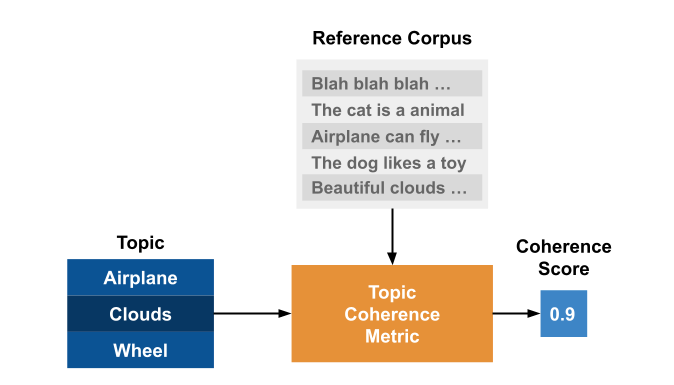

Il existe plusieurs mod√®les pour calculer un score de co√©herence *(C_v, C_p, C_uci, C_umass, C_npmi, C_a, ...)*, mais nous allons utiliser le mod√®le C_umass car il est souvent recommand√© *(mais aussi parcque c'est celui qui m'a donn√© les r√©sultats les plus rapides lors de mes tests...)*.

#### C_umass
- la mesure de coh√©rence retourn√©e par le mod√®le C_umass est n√©gative,
- plus le score est grand et plus la mesure de coh√©rence indique que le sujet est compr√©hensible par les humains.


#### Calculons les courbes de coh√©rence avec le corpus TF-IDF

In [75]:
def plot_coherence(scores, max_topics):
    plt.figure(figsize=(10, 4))
    plt.plot(range(1,max_topics), scores)
    plt.gca().xaxis.grid(True)
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(range(0,max_topics))
    plt.show()

In [76]:
score = []
max_topics = 15
for i in tqdm(range(1,max_topics,1)):
    lda_model = LdaMulticore(corpus=corpus_tfidf, id2word=dictionary, iterations=10, num_topics=i, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=lda_model, corpus=corpus_tfidf, dictionary=dictionary, coherence='u_mass')
    score.append(cm.get_coherence())

 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                                 | 8/14 [04:48<03:40, 36.68s/it]/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI

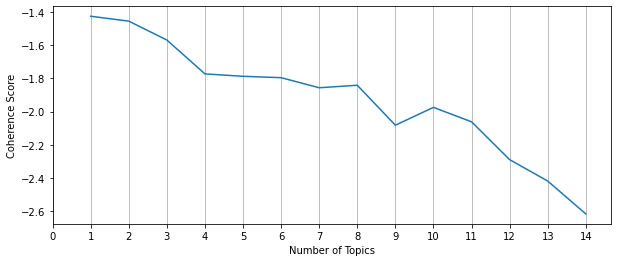

In [77]:
plot_coherence(score, max_topics)

#### Calculons les courbes de coh√©rence avec le corpus Bag-Of-Words

In [78]:
score = []
max_topics = 15
for i in tqdm(range(1,max_topics,1)):
    lda_model = LdaMulticore(corpus=corpus_bow, id2word=dictionary, iterations=10, num_topics=i, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=lda_model, corpus=corpus_bow, dictionary=dictionary, coherence='u_mass')
    score.append(cm.get_coherence())

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [03:41<00:00, 15.84s/it]


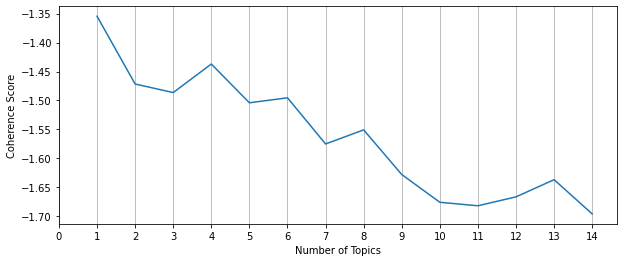

In [79]:
plot_coherence(score, max_topics)

#### ~~Calculons le score c_v~~ --> Trop long avec ce jeu de donn√©e

#### Conclusion
> En regardons l'√©volution du score de coh√©rence avec le Corpus BoW (qui est plus dapt√© pour un LDA), on constate que le nombre id√©al de sujets est de 1 ou 2... mais comme √ßa ne pr√©sente pas vraiment d'int√©r√™t, nous allons partir sur 4 qui a un score int√©ressant √©galement.

## 4.3 Logs des courbes de coh√©rences pour divers essais <a class="anchor" id="lda_coherence_logs"></a> [‚á™](#menu)

### En retirant les 100 lemmes les plus fr√©quents

#### Avec le corpus TF-IDF
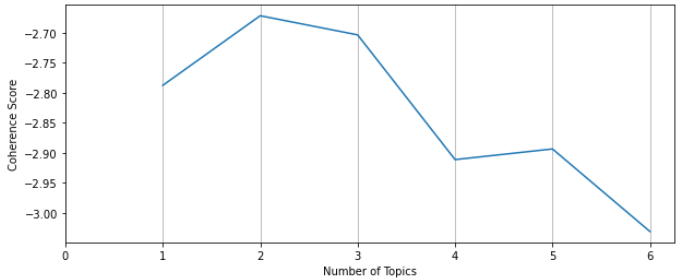

#### Avec le corpus Bag-Of-Words


### En retirant les 50 lemmes les plus fr√©quents

#### Avec le corpus TF-IDF
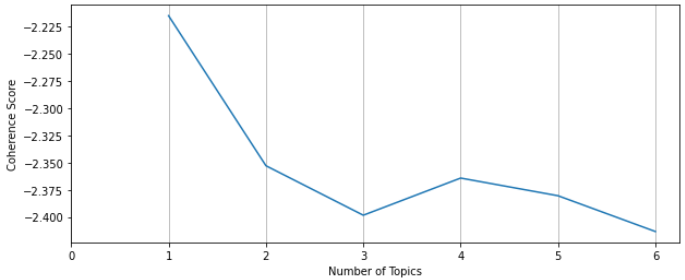

#### Avec le corpus Bag-Of-Words
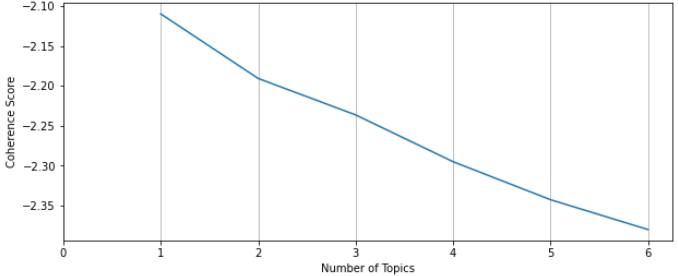

### En retirant les 5 lemmes les plus fr√©quents

#### Avec le corpus TF-IDF
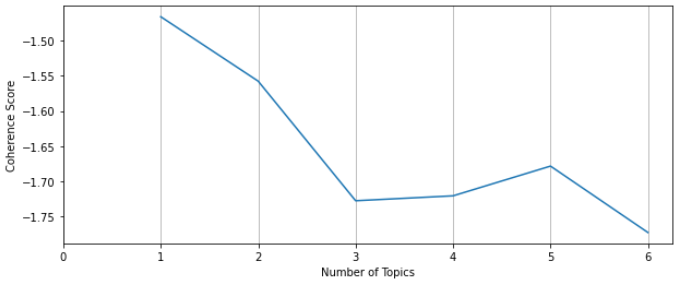

#### Avec le corpus Bag-Of-Words


### Sans retirer les lemmes les plus fr√©quents (hors dictionary.filter_extremes)

#### Avec le corpus TF-IDF


#### Avec le corpus Bag-Of-Words


---
---
# 5. Topic Modelling avec NMF<a class="anchor" id="nmf_topic_modelling"></a> [‚á™](#menu)

## 5.1 Negative Matrix Factorisation *(NMF)* <a class="anchor" id="nmf"></a> [‚á™](#menu)

In [80]:
from gensim.models import Nmf

In [81]:
import warnings
warnings.filterwarnings("ignore", message="Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.")

In [82]:
# Train the model on the corpus.
nmf = Nmf(corpus_tfidf, num_topics=10)

## 5.2 Recheche du nombre optimal de sujets <a class="anchor" id="nmf_coherence"></a> [‚á™](#menu)

#### Avec le corpus TF-IDF

In [83]:
score = []
max_topics = 15
for i in tqdm(range(1,max_topics,1)):
    nmf_model = Nmf(corpus=corpus_tfidf, num_topics=i, id2word=dictionary, passes=10, random_state=random_seed)
    #nmf_model = Nmf(corpus=corpus_tfidf, num_topics=i, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=nmf_model, corpus=corpus_tfidf, dictionary=dictionary, coherence='u_mass')
    score.append(cm.get_coherence())

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [05:38<00:00, 24.15s/it]


In [84]:
plot_coherence(score, max_topics)

#### Avec le corpus Bag-Of-Words

In [85]:
score = []
max_topics = 15
for i in tqdm(range(1,max_topics,1)):
    nmf_model = Nmf(corpus=corpus_bow, num_topics=i, id2word=dictionary, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=nmf_model, corpus=corpus_bow, dictionary=dictionary, coherence='u_mass')
    score.append(cm.get_coherence())

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [01:54<00:00,  8.19s/it]


In [86]:
plot_coherence(score, max_topics)

## 5.3 Logs des courbes de coh√©rences pour divers essais <a class="anchor" id="nmf_coherence_logs"></a> [‚á™](#menu)

### En retirant les 100 lemmes les plus fr√©quents

#### Avec le corpus TF-IDF
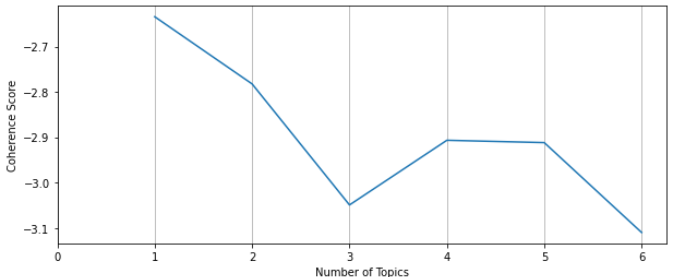

#### Avec le corpus Bag-Of-Words
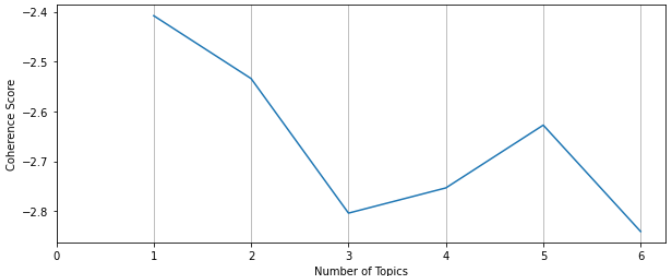

### Sans retirer les lemmes les plus fr√©quents (hors dictionary.filter_extremes)

#### Avec le corpus TF-IDF
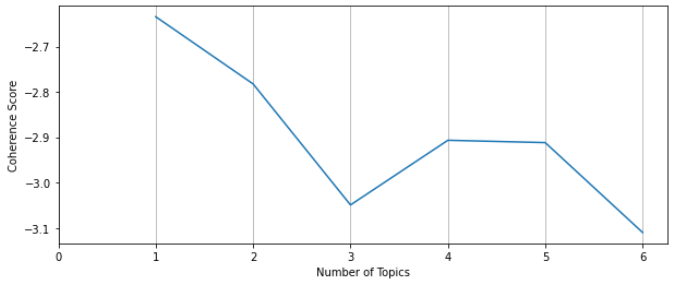

#### Avec le corpus Bag-Of-Words
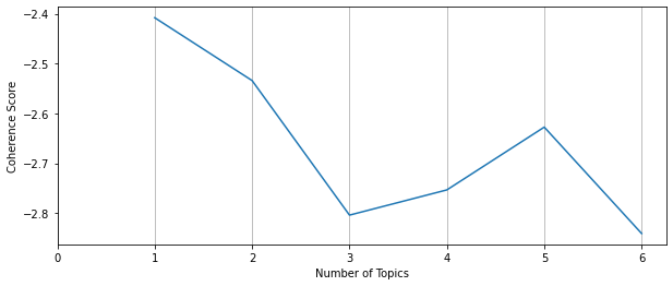

---
---
# 6. Mod√®le final<a class="anchor" id="final_model"></a> [‚á™](#menu)

## 6.1 Entrainement & interpr√©tation du meilleur mod√®le LDA <a class="anchor" id="final_model_lda"></a> [‚á™](#menu)

Nous avons vu avec les courbes de coh√©rences que le meilleur choix pour le LDA semble √™tre de chercher **4 sujets** en utilisant le **corpus Bag-Of-Words**.

### Entrainons donc le mod√®le avec le nombre de sujets optimal

In [87]:
num_topics = 4
lda_model = LdaMulticore(corpus=corpus_bow, id2word=dictionary, iterations=100, num_topics=num_topics, passes=100, random_state=random_seed)

### Affichons les lemme utilis√©s pour d√©finir les sujets et leur poids

In [100]:
lda_model.print_topics(-1)

[(0,
  '0.020*"good" + 0.019*"order" + 0.014*"place" + 0.014*"taste" + 0.013*"like" + 0.013*"chicken" + 0.012*"fry" + 0.010*"eat" + 0.009*"sauce" + 0.009*"get"'),
 (1,
  '0.032*"order" + 0.017*"time" + 0.015*"place" + 0.014*"say" + 0.013*"customer" + 0.013*"go" + 0.012*"tell" + 0.012*"service" + 0.011*"ask" + 0.009*"come"'),
 (2,
  '0.028*"pizza" + 0.022*"place" + 0.013*"good" + 0.011*"like" + 0.008*"price" + 0.008*"breakfast" + 0.008*"room" + 0.008*"coffee" + 0.008*"go" + 0.007*"look"'),
 (3,
  '0.023*"table" + 0.023*"come" + 0.022*"wait" + 0.020*"service" + 0.019*"order" + 0.017*"time" + 0.017*"minute" + 0.015*"drink" + 0.015*"ask" + 0.013*"server"')]

### Cherchons les textes qui collent le plus aux sujets pour nous aider √† les interpr√©ter

In [103]:
max_values = {}
max_index = {}
for i in range(len(corpus_bow)):
    row = dict(lda_model[corpus_bow][i])
    
    for j in range(num_topics):
        if row.get(j, 0) > max_values.get(j, 0):
            max_values[j] = row.get(j, 0)
            max_index[j] = i
            
    #if i > 10000:
    #    break
        
print(max_values)
print(max_index)

{0: 0.99551475, 1: 0.9944851, 2: 0.9932719}
{0: 7026, 1: 7562, 2: 4726}


In [90]:
explore_id = 138  # (0) 439 (1) 1252 (2) 1934 (3) x
display(lda_model[corpus_bow][explore_id])
display(data_bad_reviews['text'][explore_id])

[(0, 0.028952505), (1, 0.4433708), (2, 0.0301674), (3, 0.49750933)]

"Worst casino in America don't bother very few table games and unlike las Vegas you pay for your drinks"

### Visualisons les sujets avec pyLDAvis

Le graphique `pyLDAvis` ci-dessus repr√©sente les sujets sous forme de cercles, r√©duits en dimmensionalit√© √† l'aide d'une PCA.

Dans l'id√©al, les cercles ne doivent pas se chevaucher et m√™me maximiser la distance entre eux car les sujets les plus proches les uns des autres sont aussi les sujets les plus li√©s (donc les sujets potentiellement redondants). Lorsque l'on clique sur un cercle, les diff√©rents lemmes sont affich√©s √† droite avec leurs fr√©quences dans le corpus en bleu et leurs fr√©quences estim√©es dans le sujet s√©lectionn√© en rouge.

In [91]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_bow, dictionary)
pyLDAvis.display(lda_display)

### Interpr√©tons les sujets

In [92]:
lda_model.print_topics(-1)

[(0,
  '0.020*"good" + 0.019*"order" + 0.014*"place" + 0.014*"taste" + 0.013*"like" + 0.013*"chicken" + 0.012*"fry" + 0.010*"eat" + 0.009*"sauce" + 0.009*"get"'),
 (1,
  '0.032*"order" + 0.017*"time" + 0.015*"place" + 0.014*"say" + 0.013*"customer" + 0.013*"go" + 0.012*"tell" + 0.012*"service" + 0.011*"ask" + 0.009*"come"'),
 (2,
  '0.028*"pizza" + 0.022*"place" + 0.013*"good" + 0.011*"like" + 0.008*"price" + 0.008*"breakfast" + 0.008*"room" + 0.008*"coffee" + 0.008*"go" + 0.007*"look"'),
 (3,
  '0.023*"table" + 0.023*"come" + 0.022*"wait" + 0.020*"service" + 0.019*"order" + 0.017*"time" + 0.017*"minute" + 0.015*"drink" + 0.015*"ask" + 0.013*"server"')]

>#### On peut supposer que :
> - le `sujet 0` concerne `la qualit√© du service`.
> - le `sujet 1` concerne `le ratio qualit√© / prix ou qualit√© / attente`.
> - le `sujet 2` concerne `le temps d'attente`.
> - le `sujet 3` concerne `le go√ªt / la qualit√© de la nourriture`.

## 6.2 Entrainement & interpr√©tation du meilleur mod√®le NMF <a class="anchor" id="final_model_nmf"></a> [‚á™](#menu)

Nous avons vu avec les courbes de coh√©rences que le meilleur choix pour le LDA semble √™tre de chercher **4 sujets** en utilisant le **corpus Bag-Of-Words**.

### Entrainons donc le mod√®le avec le nombre de sujets optimal

In [93]:
num_topics = 3
nmf_model = Nmf(corpus=corpus_bow, num_topics=num_topics, id2word=dictionary, passes=10, random_state=random_seed)

### Affichons les lemme utilis√©s pour d√©finir les sujets et leur poids

In [94]:
nmf_model.print_topics(-1)

[(0,
  '0.037*"wait" + 0.030*"minute" + 0.030*"come" + 0.024*"ask" + 0.023*"time" + 0.022*"table" + 0.020*"say" + 0.020*"order" + 0.018*"tell" + 0.015*"go"'),
 (1,
  '0.083*"order" + 0.020*"pizza" + 0.011*"like" + 0.011*"place" + 0.011*"eat" + 0.010*"get" + 0.010*"fry" + 0.010*"cheese" + 0.010*"good" + 0.010*"chicken"'),
 (2,
  '0.024*"place" + 0.020*"good" + 0.013*"service" + 0.012*"like" + 0.009*"restaurant" + 0.009*"come" + 0.009*"time" + 0.008*"go" + 0.008*"bad" + 0.007*"try"')]

### Cherchons les textes qui collent le plus aux sujets pour nous aider √† les interpr√©ter

In [95]:
max_values = {}
max_index = {}
for i in range(len(corpus_bow)):
    row = dict(nmf_model[corpus_bow][i])
    
    for j in range(num_topics):
        if row.get(j, 0) > max_values.get(j, 0):
            max_values[j] = row.get(j, 0)
            max_index[j] = i
            
    if i > 2000:
        break
        
print(max_values)
print(max_index)

{1: 1.0, 2: 1.0, 0: 1.0}
{1: 27, 2: 3, 0: 8}


In [96]:
explore_id = 138  # (0) (1) (2) (3) 
display(nmf_model[corpus_bow][explore_id])
display(data_bad_reviews['text'][explore_id])

[(0, 0.7142105720338446), (2, 0.28578942796615536)]

"Worst casino in America don't bother very few table games and unlike las Vegas you pay for your drinks"

### Visualisons les sujets avec pyLDAvis

Le graphique `pyLDAvis` ci-dessus repr√©sente les sujets sous forme de cercles, r√©duits en dimmensionalit√© √† l'aide d'une PCA.

Dans l'id√©al, les cercles ne doivent pas se chevaucher et m√™me maximiser la distance entre eux car les sujets les plus proches les uns des autres sont aussi les sujets les plus li√©s (donc les sujets potentiellement redondants). Lorsque l'on clique sur un cercle, les diff√©rents lemmes sont affich√©s √† droite avec leurs fr√©quences dans le corpus en bleu et leurs fr√©quences estim√©es dans le sujet s√©lectionn√© en rouge.

In [97]:
mnf_display = pyLDAvis.gensim_models.prepare(nmf_model, corpus_bow, dictionary)
pyLDAvis.display(mnf_display)

AttributeError: 'Nmf' object has no attribute 'inference'

### Interpr√©tons les sujets

In [ ]:
lda_model.print_topics(-1)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative us

>#### On peut supposer que :
> - le `sujet 0` concerne `la qualit√© du service`.
> - le `sujet 1` concerne `le ratio qualit√© / prix ou qualit√© / attente`.
> - le `sujet 2` concerne `le temps d'attente`.
> - le `sujet 3` concerne `le go√ªt / la qualit√© de la nourriture`.

## 6.3 Export du mod√®le s√©lectionn√© <a class="anchor" id="final_model_export"></a> [‚á™](#menu)